<h1>Analysis of Azog C1 chip: current bias</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [1]:
sample_name = 'azog_c1'                    # name of the chip in the fridge

<h3>Basic imports and database loading</h3>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
db_name = '20220207_ncr_current_bias_v1.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',db_name)

qc.initialise_or_create_database_at(db_path)

In [4]:
# import sys, os
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import ticker
# import pandas as pd

# sys.path.append('/home/ncr/Programs/Anaconda/lib/python3.9/site-packages/resonator_tools-0.1-py3.9.egg')
# from resonator_tools import circuit

# import qcodes as qc
# from qcodes import initialise_database, load_by_run_spec
# from qcodes.dataset.plotting import plot_by_id

# import scipy.optimize

# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual

In [5]:
# # plot options
# plt.rc('text', usetex = True)
# plt.rc('font', family = 'serif', size=24)

In [6]:
# db_name = '20220207_ncr_current_bias_v1.db'   # name of the database
# db_path  = os.path.join(db_name)

<h2>Data analysis and plotting</h2>

<h4>VI as a function of flux</h4>

In [7]:

qc.initialise_or_create_database_at(db_path)

RUN_ID = 1
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vi_dict = dataset.to_pandas_dataframe_dict()

In [8]:
db_name = '20220131_ncr_chip_characterisation_v2.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\', db_name)

qc.initialise_or_create_database_at(db_path)


<h4>IV of the Bloch array as a function of the applied flux</h4>

In [9]:
# loading
RUN_ID = 4
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
ivf_dict = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [12]:
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()

Ib_up = ivf_up_1['current_source_current'].to_numpy()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()

Ib_down = ivf_down_1['current_source_current'].to_numpy()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

# reshape to form a 2D array
N = 20000 # hardcoded for now
size = (-1, N)

Ib_up = np.reshape(Ib_up, size)
v_up = np.reshape(v_up, size)
i_up = np.reshape(i_up, size)
Ib_down = np.reshape(Ib_down, size)
v_down = np.reshape(v_down, size)
i_down = np.reshape(i_down, size)

# divide into low-to-high and high-to-low
M = len(i_up)
zero_index_up = np.argmin(np.abs(i_up[51]))
zero_index_down = np.argmin(np.abs(i_down[51]))

v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
v_hl = np.zeros((M, zero_index_down + zero_index_up))
i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
i_hl = np.zeros((M, zero_index_down + zero_index_up))

for i in range(M):
    v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), v_up[i][zero_index_up:] ))
    v_hl[i] = np.concatenate(( v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
    i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), i_up[i][zero_index_up:] ))
    i_hl[i] = np.concatenate(( i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))

<h5>Plotting</h5>

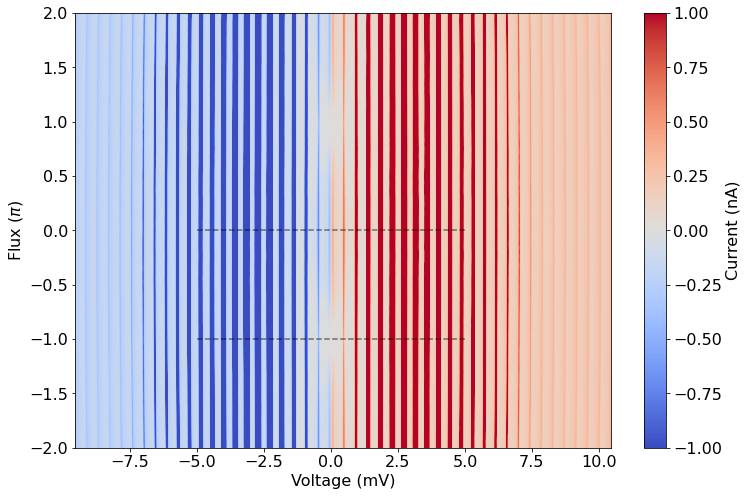

In [13]:
# plotting
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(12,8))
voltage_scaling = 1e3
voltage_offset = 0.45e-3
current_scaling = 1e9

plt.imshow(current_scaling*i_lh, aspect='auto', 
           extent=[voltage_scaling*(np.min(v_lh[0]) + voltage_offset), voltage_scaling*(np.max(v_lh[0]) + voltage_offset), -2, 2], 
           vmin = -1, vmax=1, cmap='coolwarm')
plt.xlabel('Voltage (mV)')
plt.ylabel('Flux ($\pi$)')
plt.colorbar(label='Current (nA)')

plt.hlines(-1, -5, 5, linestyles='dashed', colors='black', alpha=0.5)
plt.hlines(0, -5, 5, linestyles='dashed', colors='black', alpha=0.5)

<h5>Data shaping</h5>

In [14]:
# up ramp
vi_up_0 = vi_dict['adwin_up_ramp']
vi_up_1 = vi_up_0.reset_index()

Ib_up = vi_up_1['current_source_current'].to_numpy()
vi_v_up = vi_up_1['adwin_input_2_voltage_up'].to_numpy()
vi_i_up = vi_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vi_down_0 = vi_dict['adwin_down_ramp']
vi_down_1 = vi_down_0.reset_index()

Ib_down = vi_down_1['current_source_current'].to_numpy()
v_down = vi_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vi_down_1['adwin_down_ramp'].to_numpy()

In [15]:
# reshape to form a 2D array
N = 5040 # hardcoded for now
size = (-1, N)

Ib_up = np.reshape(Ib_up, size)
vi_i_up = np.reshape(vi_i_up, size)
vi_v_up = np.reshape(vi_v_up, size)
Ib_down = np.reshape(Ib_down, size)
i_down = np.reshape(i_down, size)
v_down = np.reshape(v_down, size)

# divide into low-to-high and high-to-low
M = len(i_up)
zero_index_up = 2595
zero_index_down = 2525

vi_v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
vi_v_hl = np.zeros((M, zero_index_down + zero_index_up))
vi_i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
vi_i_hl = np.zeros((M, zero_index_down + zero_index_up))

for i in range(M):
    vi_v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), vi_v_up[i][zero_index_up:] ))
    vi_v_hl[i] = np.concatenate(( vi_v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
    vi_i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), vi_i_up[i][zero_index_up:] ))
    vi_i_hl[i] = np.concatenate(( vi_i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))

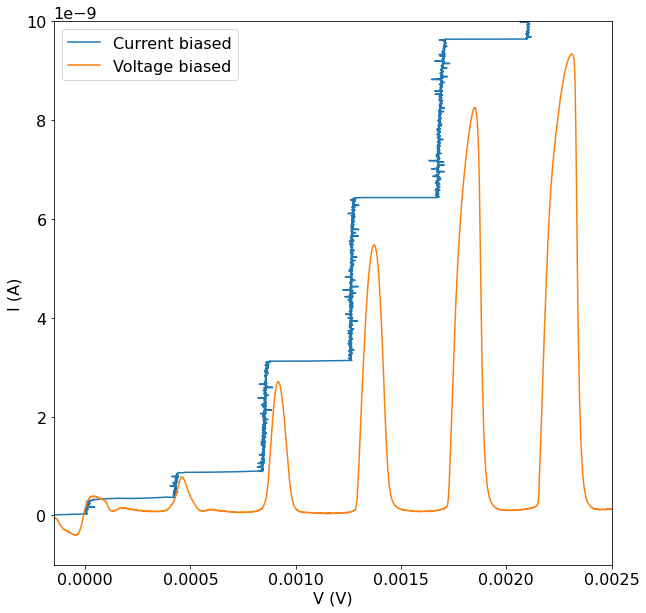

In [23]:


plt.figure(figsize=(10,10))
plt.plot(vi_v_up[50,2520:]*1e6, vi_i_up[50,2520:]*1e-6-0.2e-9, label='Current biased')
plt.plot(v_up[50,:]+0.35e-3, i_up[50,:], label='Voltage biased') # v_lh.shape[1]//2:
plt.xlim([-0.15e-3, 2.5e-3])
plt.ylim([-0.1e-8, 1e-8])
# plt.xlim([-0.15e-3, 0.15e-3])
# plt.ylim([-0.1e-8, 1e-9])
plt.ylabel("I (A)" )
plt.xlabel("V (V)")

plt.legend()

plt.savefig("currentbias_superimposed.png")

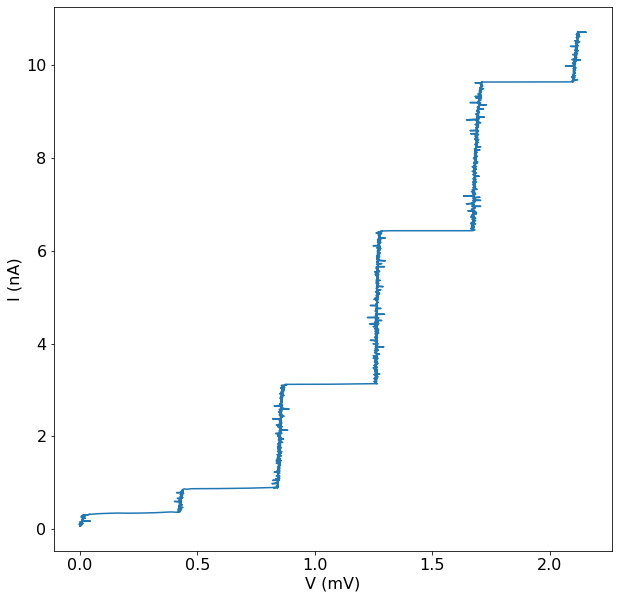

In [22]:

plt.figure(figsize=(10,10))
ki = 2600

plt.plot(vi_v_up[50,ki:]*1e6*1e3, 1e9*(vi_i_up[50,ki:]*1e-6-0.2e-9), label='Current biased')


plt.ylabel("I (nA)" )
plt.xlabel("V (mV)")
plt.savefig('current_biased.png')

<h5>Plotting</h5>

C:\Users\NICOLA~1.ROC\AppData\Local\Temp/ipykernel_19848/2483116416.py:15: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar_flux = fig.colorbar(fplot, ax=ax[0:], label='$I_0$ (nA)', cmap='RdBu', shrink=0.8)


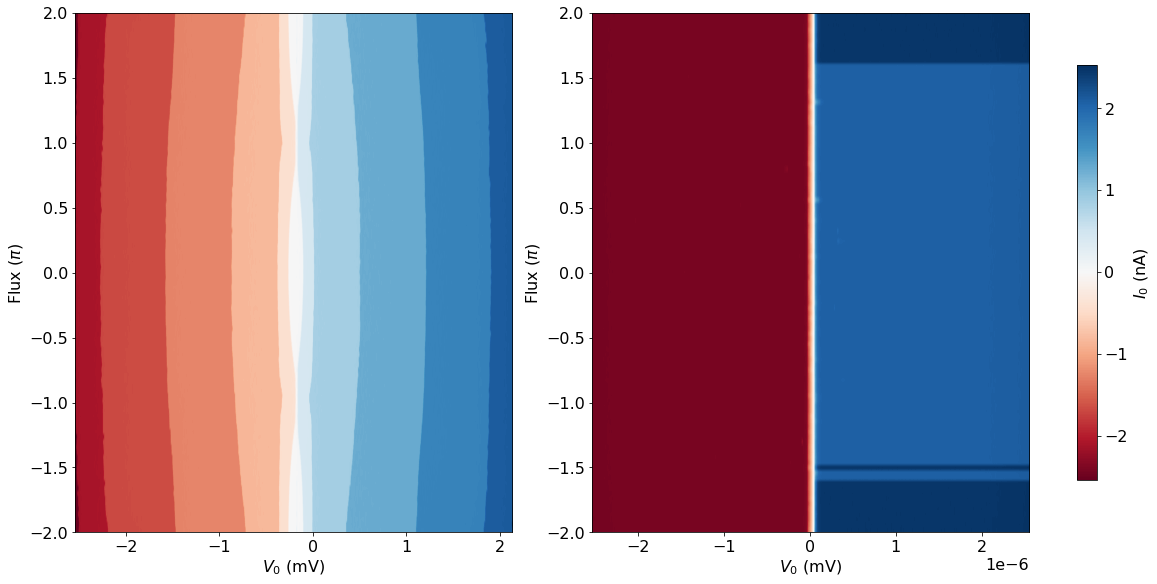

In [35]:
fig, ax = plt.subplots(1,2,figsize=(16,8), constrained_layout=True)
voltage_scale = 1e3
current_scale = 1e9

fplot = ax[0].imshow(vi_v_lh[::-1]*current_scale, aspect='auto', cmap='RdBu',
             extent = [ current_scale*np.min(vi_v_lh[0]), current_scale*np.max(vi_v_lh[0]), -2, 2 ] )
ax[0].set_xlabel('$V_0$ (mV)')
ax[0].set_ylabel('Flux ($\pi$)')

ax[1].imshow(vi_v_hl[::-1]*current_scale, aspect='auto', cmap='RdBu',
             extent = [ voltage_scale*np.min(vi_v_hl[0]), voltage_scale*np.max(vi_v_hl[0]), -2, 2 ] )
ax[1].set_xlabel('$V_0$ (mV)')
ax[1].set_ylabel('Flux ($\pi$)')

cbar_flux = fig.colorbar(fplot, ax=ax[0:], label='$I_0$ (nA)', cmap='RdBu', shrink=0.8)

5.599999999999999e-10

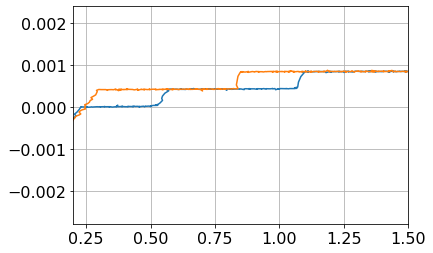

In [36]:
ind=50
plt.plot(i_up[ind]*1e3, 1e6*v_up[ind])
plt.plot(i_up[25]*1e3, 1e6*v_up[25])
plt.grid()
plt.xlim([0.2,1.5])
0.00056*1e-6

<h5>Distribution of the current peaks not at $2\Delta$</h5>

In [ ]:
n = np.linspace(1, 6, 6)
peaks = [37, 100, 186, 424, 800, 1100]

fit_par = np.polyfit(n, peaks, 2)
fit = np.poly1d(fit_par)

plt.plot( n, peaks, 'o' )
plt.plot( np.linspace(1,6,1001), fit(np.linspace(1,6,1001)) )